# 16. 행동 스티커 만들기

# 16-1. 데이터셋을 어디에서 구할까?

### MPII 데이터셋 다운로드하기
MPII Human Pose Dataset을 사용해서 Human Pose Estimation task를 위한 모델을 훈련시켜보자.

![](https://d3s0tskafalll9.cloudfront.net/media/images/GC-10-P-1.max-800x600.png)

미리 준비된 데이터셋에 다음과 같은 과정이 필요하다.

```
# ray 라이브러리 설치가 필요합니다.
pip install ray

# mpii 폴더로 이동
cd YOUR_PATH/mpii

# 이미 파일들이 다 올라가 있으니 따로 업로드 하실 건 없습니다.
# zip파일을 한꺼번에 압축 풀기
!unzip '*.zip'

# tar 파일 압축 풀기
!tar -xvf mpii_human_pose_v1.tar.gz -C .

# mpii_human_pose_v1_u12_2 폴더로 이동
cd mpii_human_pose_v1_u12_2

# json 파일 다운로드
!wget https://d3s0tskafalll9.cloudfront.net/media/documents/train.json
!wget https://d3s0tskafalll9.cloudfront.net/media/documents/validation.json

# 작업 폴더로 이동
cd ..
```

In [1]:
!pip install ray==1.7.0

# 16-2. 데이터 전처리하기

In [2]:
# 주의! ray를 tensorflow보다 먼저 import하면 오류가 발생할 수 있습니다
import io, json, os, math

import tensorflow as tf
from tensorflow.keras.layers import Add, Concatenate, Lambda
from tensorflow.keras.layers import Input, Conv2D, ReLU, MaxPool2D
from tensorflow.keras.layers import UpSampling2D, ZeroPadding2D
from tensorflow.keras.layers import BatchNormalization
import ray

import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

PROJECT_PATH = '/content/drive/MyDrive/aiffel_dataset/GD16_human_pose_sticker/mpii/'
IMAGE_PATH = os.path.join(PROJECT_PATH, 'images')
MODEL_PATH = os.path.join(PROJECT_PATH, 'models')
TFRECORD_PATH = os.path.join(PROJECT_PATH, 'tfrecords_mpii')
TRAIN_JSON = os.path.join(PROJECT_PATH, 'mpii_human_pose_v1_u12_2', 'train.json')
VALID_JSON = os.path.join(PROJECT_PATH, 'mpii_human_pose_v1_u12_2', 'validation.json')

print('슝=3')

슝=3


### json 파싱하기
`train.json`, `validation.json` 파일을 다운받았다. 이 파일들은 이미지에 담겨 있는 사람들의 pose keypoint 정보들을 갖고 있어 Pose Estimation을 위한 label로 삼을 수 있따.

먼저 json이 어떻게 구성되어있는지 샘플로 annotation 정보를 1개만 출력해보자.   
`json.dumps()`를 활용해서 좀 더 명확하게 하면 더 좋다.

In [3]:
with open(TRAIN_JSON) as train_json:
    train_annos = json.load(train_json)
    json_formatted_str = json.dumps(train_annos[0], indent=2)
    print(json_formatted_str)

{
  "joints_vis": [
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1
  ],
  "joints": [
    [
      620.0,
      394.0
    ],
    [
      616.0,
      269.0
    ],
    [
      573.0,
      185.0
    ],
    [
      647.0,
      188.0
    ],
    [
      661.0,
      221.0
    ],
    [
      656.0,
      231.0
    ],
    [
      610.0,
      187.0
    ],
    [
      647.0,
      176.0
    ],
    [
      637.0201,
      189.8183
    ],
    [
      695.9799,
      108.1817
    ],
    [
      606.0,
      217.0
    ],
    [
      553.0,
      161.0
    ],
    [
      601.0,
      167.0
    ],
    [
      692.0,
      185.0
    ],
    [
      693.0,
      240.0
    ],
    [
      688.0,
      313.0
    ]
  ],
  "image": "015601864.jpg",
  "scale": 3.021046,
  "center": [
    594.0,
    257.0
  ]
}


`joints`가 우리가 label로 사용할 keypoint의 label이다.   
이미지 형상과 사람의 포즈에 따라 모든 label이 이미지에 나타나지 않기 때문에 `joints_vis`를 이용해서 실제 사용할 수 있는 keypoint 인지 나타낸다.   
MPII의 경우 1(visible), 0(non)으로만 나누어지기 때문에 조금 더 쉽게 사용할 수 있다. coco의 경우 2, 1, 0으로 표현해서 occlusion 상황까지 label화 되어 있다.

`joint` 순서는 아래와 같은 순서로 배치되어 저장했다.   
- 0- 오른쪽 발목, 1- 오른쪽 무릎, 2- 오른쪽 엉덩이, 3- 왼쪽 엉덩이, 4- 왼쪽 무릎, 5- 왼쪽 발목
- 6- 골반, 7- 가슴(흉부), 8- 목, 9- 머리 위
- 10- 오른쪽 손목, 11- 오른쪽 팔꿈치, 12- 오른쪽 어깨, 13- 왼쪽 어깨, 14- 왼쪽 팔꿈치, 15- 왼쪽 손목

`scale`, `center`는 사람 몸의 크기와 중심점이다. `scale`은 200을 곱해야 온전한 크기가 된다.

json annotation을 파싱하는 함수를 만들어보자.

In [4]:
def parse_one_annotation(anno, image_dir):
    filename = anno['image']
    joints = anno['joints']
    joints_visibility = anno['joints_vis']
    annotation = {
        'filename': filename,
        'filepath': os.path.join(image_dir, filename),
        'joints_visibility': joints_visibility,
        'joints': joints,
        'center': anno['center'],
        'scale' : anno['scale']
    }
    return annotation

print('슝=3')

슝=3


위 함수를 테스트해보자.

In [5]:
with open(TRAIN_JSON) as train_json:
    train_annos = json.load(train_json)
    test = parse_one_annotation(train_annos[0], IMAGE_PATH)
    print(test)

{'filename': '015601864.jpg', 'filepath': '/content/drive/MyDrive/aiffel_dataset/GD16_human_pose_sticker/mpii/images/015601864.jpg', 'joints_visibility': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'joints': [[620.0, 394.0], [616.0, 269.0], [573.0, 185.0], [647.0, 188.0], [661.0, 221.0], [656.0, 231.0], [610.0, 187.0], [647.0, 176.0], [637.0201, 189.8183], [695.9799, 108.1817], [606.0, 217.0], [553.0, 161.0], [601.0, 167.0], [692.0, 185.0], [693.0, 240.0], [688.0, 313.0]], 'center': [594.0, 257.0], 'scale': 3.021046}


# 16-3. TFRecord 파일 만들기

### TFRecord 파일 만들기
이전 프로젝트에서는 tf.keras의 `ImageDataGenerator`를 이용해서 주로 학습 데이터를 읽었다. 하지만 실제 프로젝트는 튜토리얼 데이터셋보다 훨씬 큰 크기의 데이터를 다뤄야 한다.

학습을 많이 해볼수록 학습 속도에 관심을 갖게 되는데, tensorflow 튜토리얼 문서에는 다음과 같은 표현으로 나타나 있다.   
> unless you are using tf.data and reading data is still the bottleneck to training

일반적으로 학습 과정에서 gpu의 연산 속도보다 HDD I/O 속도가 느리기 때문에 병목 현상이 발생하고 대단위 프로젝트 실험에서 효율성이 떨어지는 것을 관찰할 수 있다.   
따라서 학습 데이터를 어떻게 빠르가 읽는가? 에 대한 고민을 반드시 수행해야 더 많은 실험을 할 수 있다.

- [tf.data API로 성능 향상하기](https://www.tensorflow.org/guide/data_performance?hl=ko)

학습 속도를 향상시키기 위해 데이터 변환이 병렬화되어야 한다. 그래서 데이터를 읽거나 가져올때(prefetch) 또는 데이터 변환 단계에서 gpu 학습과 병렬적으로 수행되도도록 prefetch를 적용해야 한다.   
수행하기 위해 `tf.data.Dataset.map` 변환을 제공하는 함수를 이용하고 이를 캐시에 저장하여 학습이 끝나면 바로 변환된 데이터를 제공해야한다.

tf에서 위 변환을 자동화해주는 도구를 제공한다. 데이터셋을 TFRecord 형태로 표현하는 것인데, 이는 binary record sequence를 저장하기 위한 형식이다. 그리고 내부적으로 protocol buffer를 이용한다.   
- [https://developers.google.com/protocol-buffers/?hl=ko](https://developers.google.com/protocol-buffers/?hl=ko)

protocol buffer는 크로스 플랫폼에서 사용할 수 있는 직렬화 데이터 라이브러리라 생각하면 된다.

데이터를 직렬화 한다는 것은 의미가 있는 정보만 추출해 나열하는 것을 말한다.   
예를들어 "서울 강동구에 사는 30살 손흥민"을 나타내기 위해 "서울강동30손흥민"으로 쓴다면 데이터만 남을 수 있다.   
데이터 형식을 고정해야 하기 때문에 첫 두 글자는 시를 뜻하고, 다음 두 글자는 구를, 다음 두 자리는 숫자가 나오고, 이름은 세 글자여야 하는 제한이 생긴다.   
100살이 넘는 사람이나 이름이 세 글자가 아니라면 형식에서 벗어날 수 있다. 그래서 매우 정형화된 데이터를 직렬화 하면 데이터 크기와 처리 속도 측면에서 유리하지만 사용하는데 제한이 있다고 기억해두자. 어떤 데이터에서 어떠한 방법으로 직렬화를 수행할지에 따라 발생되는 제한이 달라질 수도 있다.

구현을 시작해보자.   
앞서 추출한 annotation을 TFRecord로 변환하는 함수를 만들자. TFRecord는 `tf.train.Example`들의 합으로 이루어지므로 하나의 annotation을 하나의 `tf.train.Example`로 만들어주는 함수부터 작성해야한다.

In [6]:
def generate_tfexample(anno):

    # byte 인코딩을 위한 함수
    def _bytes_feature(value):
        if isinstance(value, type(tf.constant(0))):
            value = value.numpy()
        return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

    filename = anno['filename']
    filepath = anno['filepath']
    with open(filepath, 'rb') as image_file:
        content = image_file.read()

    image = Image.open(filepath)
    if image.format != 'JPEG' or image.mode != 'RGB':
        image_rgb = image.convert('RGB')
        with io.BytesIO() as output:
            image_rgb.save(output, format="JPEG", quality=95)
            content = output.getvalue()

    width, height = image.size
    depth = 3

    c_x = int(anno['center'][0])
    c_y = int(anno['center'][1])
    scale = anno['scale']

    x = [
        int(joint[0]) if joint[0] >= 0 else int(joint[0]) 
        for joint in anno['joints']
    ]
    y = [
        int(joint[1]) if joint[1] >= 0 else int(joint[0]) 
        for joint in anno['joints']
    ]

    v = [0 if joint_v == 0 else 2 for joint_v in anno['joints_visibility']]

    feature = {
        'image/height':
        tf.train.Feature(int64_list=tf.train.Int64List(value=[height])),
        'image/width':
        tf.train.Feature(int64_list=tf.train.Int64List(value=[width])),
        'image/depth':
        tf.train.Feature(int64_list=tf.train.Int64List(value=[depth])),
        'image/object/parts/x':
        tf.train.Feature(int64_list=tf.train.Int64List(value=x)),
        'image/object/parts/y':
        tf.train.Feature(int64_list=tf.train.Int64List(value=y)),
        'image/object/center/x': 
        tf.train.Feature(int64_list=tf.train.Int64List(value=[c_x])),
        'image/object/center/y': 
        tf.train.Feature(int64_list=tf.train.Int64List(value=[c_y])),
        'image/object/scale':
        tf.train.Feature(float_list=tf.train.FloatList(value=[scale])),
        'image/object/parts/v':
        tf.train.Feature(int64_list=tf.train.Int64List(value=v)),
        'image/encoded':
        _bytes_feature(content),
        'image/filename':
        _bytes_feature(filename.encode())
    }

    return tf.train.Example(features=tf.train.Features(feature=feature))

print('슝=3')

슝=3


하나의 annotation이 `tf.train.Example`이 되었다면 이제 여러 annotation에 대해 작업할 수 있도록 함수를 만들어보자.

여기서 하나의 TFRecord를 만들지 않고 여러 TFRecord를 만들어보자. 먼저 얼마나 많은 TFRecord를 만들지 결정할 함수를 만들자.

In [7]:
def chunkify(l, n):
    size = len(l) // n
    start = 0
    results = []
    for i in range(n):
        results.append(l[start:start + size])
        start += size
    return results

print('슝=3')

슝=3


이 함수는 전체 데이터를 몇 개의 그룹으로 나눌지 결정해준다. 전체 데이터 `l`을 `n`그룹으로 나눈다. 결과적으로 `n`개의 TFRecord 파일을 만들겠다는 이야기이다.

더 전문적으로 `n`개로 shard 했다고 말한다.   
기업 단위의 데이터는 매우 크고 여러 장비에 나누어져 있기 때문에 sharding은 자주 이뤄진다. 하나의 큰 데이터를 여러 개의 파일로 쪼개고 여러 컴퓨터에 나누어 담는 것이라고 여기면 된다. 이렇게 하면 데이터 저장, 병렬 처리하는데 이점이 있다.

데이터는 원래 하나의 큰 데이터였기 때문에 저장 후 어떻게 사용할 것인가에 따라 sharding 전략이 달라진다. 이번에는 간단히 다뤄보자.   
모델을 학습하는데 각 파일의 크기와 개수만 고려하면, 너무 작은 파일로 많이 나누는 것도, 너무 큰 파일로 적게 나누는 것도 좋지 않다. 너무 작은 파일로 많이 나누면 학습 중간에 잦은 입출력이 요구되고, 너무 큰 파일로 적게 나누면 입출려감다 걸리는 시간이 길어진다. 입출력에 걸리는 시간이 GPU 계산 시간보다 길어지면 그만큼 손해가 된다.   
적절한 파일 크기와 개수는 케바케라고 할 수 있다.

- [TFRecord 및 tf.train.Example](https://www.tensorflow.org/tutorials/load_data/tfrecord?hl=ko)

위 링크를 참고하면 annotation을 shard로 왜 나눠야하는지 알 수 있다.   
I/O 병목현상을 피하기 위해 입력 파일을 여러개로 나눈 뒤 병렬적으로 prefetch 하는 것이 학습 속도를 빠르게 한다.   
참고를 보면 데이터를 읽는 호스트보다 최소 10배 많은 파일을 보유하는게 좋다고 한다. 각 파일은 동시에 I/O prefetch의 이점을 누릴 수 있도록 충분히 커야한다고 나와있다.(최소 10MB 이상, 이상적으로 100MB 이상)

설명은 어렵지만 실행하면 단순하다. `chunkify` 함수를 테스트해보자.

In [8]:
test_chunks = chunkify([0] * 1000, 64)
print(test_chunks)
print(len(test_chunks))
print(len(test_chunks[0]))

[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0,

0이 1000개가 들어있는 리스트를 64개 만들었다.   
하나의 chunk를 TFRecord로 만들어 줄 함수를 만들자.

In [9]:
@ray.remote
def build_single_tfrecord(chunk, path):
    print('start to build tf records for ' + path)

    with tf.io.TFRecordWriter(path) as writer:
        for anno in chunk:
            tf_example = generate_tfexample(anno)
            writer.write(tf_example.SerializeToString())

    print('finished building tf records for ' + path)

print('슝=3')

슝=3


`chunk`안에 여러 annotation이 있고, 이들은 `tf.train.Example`로 변환된 후에 문자열로 직렬화되어 TFRecord에 담긴다.

한 가지 주의할 점은 함수 정의 위에 `@ray.remote`가 있다는 점이다.

- [RAY](https://www.ray.io/)

Ray는 병렬 처리를 위한 라이브러리로, 파이썬에서 기본적으로 제공하는 multiprocession 패키지보다 편하게 다양한 환경에서 사용할 수 있다.

준비가 끝났으니 전체 데이터를 적당한 수의 TFRecord 파일로 만들어주는 함수를 만들어보자. ray를 사용하기 때문에 함수를 호출하는 문법이 약간 다르다.

In [10]:
def build_tf_records(annotations, total_shards, split):
    chunks = chunkify(annotations, total_shards)
    futures = [
        build_single_tfrecord.remote(
            chunk, '{}/{}_{}_of_{}.tfrecords'.format(
                TFRECORD_PATH,
                split,
                str(i + 1).zfill(4),
                str(total_shards).zfill(4),
            )) for i, chunk in enumerate(chunks)
    ]
    ray.get(futures)

print('슝=3')

슝=3


# 16-4. Ray

위에서 작성한 함수를 사용해 데이터를 TFRecord로 만들어주자.   
train 데이터는 64개, val 데이터는 8개의 파일로 만들자.

In [11]:
num_train_shards = 64
num_val_shards = 8

ray.init()

print('Start to parse annotations.')
if not os.path.exists(TFRECORD_PATH):
    os.makedirs(TFRECORD_PATH)

with open(TRAIN_JSON) as train_json:
    train_annos = json.load(train_json)
    train_annotations = [
        parse_one_annotation(anno, IMAGE_PATH)
        for anno in train_annos
    ]
    print('First train annotation: ', train_annotations[0])

with open(VALID_JSON) as val_json:
    val_annos = json.load(val_json)
    val_annotations = [
        parse_one_annotation(anno, IMAGE_PATH) 
        for anno in val_annos
    ]
    print('First val annotation: ', val_annotations[0])
    
print('Start to build TF Records.')
build_tf_records(train_annotations, num_train_shards, 'train')
build_tf_records(val_annotations, num_val_shards, 'val')

print('Successfully wrote {} annotations to TF Records.'.format(
    len(train_annotations) + len(val_annotations)))

Start to parse annotations.
First train annotation:  {'filename': '015601864.jpg', 'filepath': '/content/drive/MyDrive/aiffel_dataset/GD16_human_pose_sticker/mpii/images/015601864.jpg', 'joints_visibility': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'joints': [[620.0, 394.0], [616.0, 269.0], [573.0, 185.0], [647.0, 188.0], [661.0, 221.0], [656.0, 231.0], [610.0, 187.0], [647.0, 176.0], [637.0201, 189.8183], [695.9799, 108.1817], [606.0, 217.0], [553.0, 161.0], [601.0, 167.0], [692.0, 185.0], [693.0, 240.0], [688.0, 313.0]], 'center': [594.0, 257.0], 'scale': 3.021046}
First val annotation:  {'filename': '005808361.jpg', 'filepath': '/content/drive/MyDrive/aiffel_dataset/GD16_human_pose_sticker/mpii/images/005808361.jpg', 'joints_visibility': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'joints': [[804.0, 711.0], [816.0, 510.0], [908.0, 438.0], [1040.0, 454.0], [906.0, 528.0], [883.0, 707.0], [974.0, 446.0], [985.0, 253.0], [982.7591, 235.9694], [962.2409, 80.0306], [869.0, 

(pid=2041) 2022-04-24 13:10:48.556518: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
(pid=2040) 2022-04-24 13:10:49.131364: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


(build_single_tfrecord pid=2040) start to build tf records for /content/drive/MyDrive/aiffel_dataset/GD16_human_pose_sticker/mpii/tfrecords_mpii/train_0001_of_0064.tfrecords
(build_single_tfrecord pid=2041) finished building tf records for /content/drive/MyDrive/aiffel_dataset/GD16_human_pose_sticker/mpii/tfrecords_mpii/train_0002_of_0064.tfrecords
(build_single_tfrecord pid=2041) start to build tf records for /content/drive/MyDrive/aiffel_dataset/GD16_human_pose_sticker/mpii/tfrecords_mpii/train_0003_of_0064.tfrecords
(build_single_tfrecord pid=2040) finished building tf records for /content/drive/MyDrive/aiffel_dataset/GD16_human_pose_sticker/mpii/tfrecords_mpii/train_0001_of_0064.tfrecords
(build_single_tfrecord pid=2040) start to build tf records for /content/drive/MyDrive/aiffel_dataset/GD16_human_pose_sticker/mpii/tfrecords_mpii/train_0004_of_0064.tfrecords
(build_single_tfrecord pid=2041) finished building tf records for /content/drive/MyDrive/aiffel_dataset/GD16_human_pose_stic

Ray에 대해 더 알아보자
- [What is Ray?](https://docs.ray.io/en/latest/)

위 자료에 주어진 예시 코드를 보면 ray를 사용하는 방법이 있다.   
```
import ray
ray.init()

@ray.remote
def f(x):
    return x * x

futures = [f.remote(i) for i in range(4)]
print(ray.get(futures)) # [0, 1, 4, 9]

@ray.remote
class Counter(object):
    def __init__(self):
        self.n = 0

    def increment(self):
        self.n += 1

    def read(self):
        return self.n

counters = [Counter.remote() for i in range(4)]
[c.increment.remote() for c in counters]
futures = [c.read.remote() for c in counters]
print(ray.get(futures)) # [1, 1, 1, 1]
```

함수나 클래스에 `@ray.remote` 데코레이터를 붙이고 `some_function.remote()` 형식으로 함수를 만든다.   
클래스의 경우 메서드를 호출할 때 `remote()`를 이용한다. 함수나 메서드는 이 시점에 실행이 아닌 생성만 된다. 그리고 `ray.get()`을 통해 실행이 되는 구조이다.   
함수를 바로 호출하는게 아닌 작업 생성만 해놓고 나중에 실행한다는 점을 유의하자.

- [10x Faster Parallel Python Without Python Multiprocessing(https://towardsdatascience.com/10x-faster-parallel-python-without-python-multiprocessing-e5017c93cce1)

multiprocessing과 ray의 사용상 큰 차이점은 multiprocessing은 병렬화를 위해 추상적 구조를 새로 설계해야 하지만 ray는 쓰던 코드에서 거의 수정 없이 병렬화 할 수 있는 장점이 있다.

# 16-5. data label로 만들기

TFRecord로 저장된 데이터를 모델의 학습에 필요한 데이터로 바꿔줄 함수가 필요하다. tensorflow에서 이미 제공해주는 함수를 사용하면 되기 때문에 간단하다.   
주의할 점은 TFRecord가 직렬화된 데이터이기 때문에 만들 때 데이터 순서와 읽어올 때 데이터 순서가 같아야 한다는 점이다. 데이터의 형식도 동일하게 맞춰야 한다.

In [12]:
def parse_tfexample(example):
    image_feature_description = {
        'image/height': tf.io.FixedLenFeature([], tf.int64),
        'image/width': tf.io.FixedLenFeature([], tf.int64),
        'image/depth': tf.io.FixedLenFeature([], tf.int64),
        'image/object/parts/x': tf.io.VarLenFeature(tf.int64),
        'image/object/parts/y': tf.io.VarLenFeature(tf.int64),
        'image/object/parts/v': tf.io.VarLenFeature(tf.int64),
        'image/object/center/x': tf.io.FixedLenFeature([], tf.int64),
        'image/object/center/y': tf.io.FixedLenFeature([], tf.int64),
        'image/object/scale': tf.io.FixedLenFeature([], tf.float32),
        'image/encoded': tf.io.FixedLenFeature([], tf.string),
        'image/filename': tf.io.FixedLenFeature([], tf.string),
    }
    return tf.io.parse_single_example(example, image_feature_description)

print('슝=3')

슝=3


이렇게 얻은 image와 label을 이용해서 적절한 학습 형태로 변환한다. 이미지를 그대로 사용하지 않고 적당히 정사각형으로 crop하여 사용한다.

우리가 알고 있는 정보는 joints의 위치, center의 좌표, body height값이다. 균일하게 학습하기 위해 body width를 적절히 정하는 것도 중요하다. 이와 관련해서 여러 방법이 있을 수 있겠지만 배우는 단계에서 더 중요하게 봐야 할 부분은 우리가 임의로 조정한 crop box가 이미지 바깥으로 나가지 않는지 예외 처리를 잘 해주어야 한다는 점이다.

In [13]:
def crop_roi(image, features, margin=0.2):
    img_shape = tf.shape(image)
    img_height = img_shape[0]
    img_width = img_shape[1]
    img_depth = img_shape[2]

    keypoint_x = tf.cast(tf.sparse.to_dense(features['image/object/parts/x']), dtype=tf.int32)
    keypoint_y = tf.cast(tf.sparse.to_dense(features['image/object/parts/y']), dtype=tf.int32)
    center_x = features['image/object/center/x']
    center_y = features['image/object/center/y']
    body_height = features['image/object/scale'] * 200.0

    # keypoint 중 유효한값(visible = 1) 만 사용합니다.
    masked_keypoint_x = tf.boolean_mask(keypoint_x, keypoint_x > 0)
    masked_keypoint_y = tf.boolean_mask(keypoint_y, keypoint_y > 0)

    # min, max 값을 찾습니다.
    keypoint_xmin = tf.reduce_min(masked_keypoint_x)
    keypoint_xmax = tf.reduce_max(masked_keypoint_x)
    keypoint_ymin = tf.reduce_min(masked_keypoint_y)
    keypoint_ymax = tf.reduce_max(masked_keypoint_y)

    # 높이 값을 이용해서 x, y 위치를 재조정 합니다. 박스를 정사각형으로 사용하기 위해 아래와 같이 사용합니다.
    xmin = keypoint_xmin - tf.cast(body_height * margin, dtype=tf.int32)
    xmax = keypoint_xmax + tf.cast(body_height * margin, dtype=tf.int32)
    ymin = keypoint_ymin - tf.cast(body_height * margin, dtype=tf.int32)
    ymax = keypoint_ymax + tf.cast(body_height * margin, dtype=tf.int32)

    # 이미지 크기를 벗어나는 점을 재조정 해줍니다.
    effective_xmin = xmin if xmin > 0 else 0
    effective_ymin = ymin if ymin > 0 else 0
    effective_xmax = xmax if xmax < img_width else img_width
    effective_ymax = ymax if ymax < img_height else img_height
    effective_height = effective_ymax - effective_ymin
    effective_width = effective_xmax - effective_xmin

    image = image[effective_ymin:effective_ymax, effective_xmin:effective_xmax, :]
    new_shape = tf.shape(image)
    new_height = new_shape[0]
    new_width = new_shape[1]

    effective_keypoint_x = (keypoint_x - effective_xmin) / new_width
    effective_keypoint_y = (keypoint_y - effective_ymin) / new_height

    return image, effective_keypoint_x, effective_keypoint_y

print('슝=3')

슝=3
(build_single_tfrecord pid=2041) finished building tf records for /content/drive/MyDrive/aiffel_dataset/GD16_human_pose_sticker/mpii/tfrecords_mpii/val_0008_of_0008.tfrecords


![](https://d3s0tskafalll9.cloudfront.net/media/images/GC-10-P-2.max-800x600.png)

(x, y) 좌표로 되어있는 keypoint를 heatmap으로 변경한다. 하나의 점에만 표시 되어있는 정보를 좌표 근처 여러 지점에 확률 분포 형태로 학습시키면 결과가 더 좋았던 케이스가 있다. 이러한 확률 분포 형태의 정보를 heatmap이라고 부른다.   
확률 분포로는 2차원 가우시안 분포를 사용한다.

![](https://d3s0tskafalll9.cloudfront.net/media/original_images/GC-10-P-3.png)

In [14]:
def generate_2d_guassian(height, width, y0, x0, visibility=2, sigma=1, scale=12):
    heatmap = tf.zeros((height, width))

    xmin = x0 - 3 * sigma
    ymin = y0 - 3 * sigma
    xmax = x0 + 3 * sigma
    ymax = y0 + 3 * sigma
    
    if xmin >= width or ymin >= height or xmax < 0 or ymax < 0 or visibility == 0:
        return heatmap

    size = 6 * sigma + 1
    x, y = tf.meshgrid(tf.range(0, 6 * sigma + 1, 1), tf.range(0, 6 * sigma + 1, 1), indexing='xy')

    center_x = size // 2
    center_y = size // 2

    gaussian_patch = tf.cast(tf.math.exp(
        -(tf.math.square(x - center_x) + tf.math.square(y - center_y)) / (tf.math.square(sigma) * 2)) * scale,
                             dtype=tf.float32)

    patch_xmin = tf.math.maximum(0, -xmin)
    patch_ymin = tf.math.maximum(0, -ymin)
    patch_xmax = tf.math.minimum(xmax, width) - xmin
    patch_ymax = tf.math.minimum(ymax, height) - ymin

    heatmap_xmin = tf.math.maximum(0, xmin)
    heatmap_ymin = tf.math.maximum(0, ymin)
    heatmap_xmax = tf.math.minimum(xmax, width)
    heatmap_ymax = tf.math.minimum(ymax, height)

    indices = tf.TensorArray(tf.int32, 1, dynamic_size=True)
    updates = tf.TensorArray(tf.float32, 1, dynamic_size=True)

    count = 0

    for j in tf.range(patch_ymin, patch_ymax):
        for i in tf.range(patch_xmin, patch_xmax):
            indices = indices.write(count, [heatmap_ymin + j, heatmap_xmin + i])
            updates = updates.write(count, gaussian_patch[j][i])
            count += 1

    heatmap = tf.tensor_scatter_nd_update(heatmap, indices.stack(), updates.stack())

    return heatmap

def make_heatmaps(features, keypoint_x, keypoint_y, heatmap_shape):
    v = tf.cast(tf.sparse.to_dense(features['image/object/parts/v']), dtype=tf.float32)
    x = tf.cast(tf.math.round(keypoint_x * heatmap_shape[0]), dtype=tf.int32)
    y = tf.cast(tf.math.round(keypoint_y * heatmap_shape[1]), dtype=tf.int32)

    num_heatmap = heatmap_shape[2]
    heatmap_array = tf.TensorArray(tf.float32, 16)

    for i in range(num_heatmap):
        gaussian = self.generate_2d_guassian(heatmap_shape[1], heatmap_shape[0], y[i], x[i], v[i])
        heatmap_array = heatmap_array.write(i, gaussian)

    heatmaps = heatmap_array.stack()
    heatmaps = tf.transpose(heatmaps, perm=[1, 2, 0])  # change to (64, 64, 16)

    return heatmaps

print('슝=3')

슝=3


지금까지 만든 함수들을 객체 형태로 조합해보자. 객체 형태로 만들면 선언부는 복잡해 보여도 훨씬 장점이 많다.   
함수에서 객체의 메서드로 수정할 때는 `self`를 추가해야 한다.

In [15]:
class Preprocessor(object):
    def __init__(self,
                 image_shape=(256, 256, 3),
                 heatmap_shape=(64, 64, 16),
                 is_train=False):
        self.is_train = is_train
        self.image_shape = image_shape
        self.heatmap_shape = heatmap_shape

    def __call__(self, example):
        features = self.parse_tfexample(example)
        image = tf.io.decode_jpeg(features['image/encoded'])

        if self.is_train:
            random_margin = tf.random.uniform([1], 0.1, 0.3)[0]
            image, keypoint_x, keypoint_y = self.crop_roi(image, features, margin=random_margin)
            image = tf.image.resize(image, self.image_shape[0:2])
        else:
            image, keypoint_x, keypoint_y = self.crop_roi(image, features)
            image = tf.image.resize(image, self.image_shape[0:2])

        image = tf.cast(image, tf.float32) / 127.5 - 1
        heatmaps = self.make_heatmaps(features, keypoint_x, keypoint_y, self.heatmap_shape)

        return image, heatmaps

        
    def crop_roi(self, image, features, margin=0.2):
        img_shape = tf.shape(image)
        img_height = img_shape[0]
        img_width = img_shape[1]
        img_depth = img_shape[2]

        keypoint_x = tf.cast(tf.sparse.to_dense(features['image/object/parts/x']), dtype=tf.int32)
        keypoint_y = tf.cast(tf.sparse.to_dense(features['image/object/parts/y']), dtype=tf.int32)
        center_x = features['image/object/center/x']
        center_y = features['image/object/center/y']
        body_height = features['image/object/scale'] * 200.0
        
        masked_keypoint_x = tf.boolean_mask(keypoint_x, keypoint_x > 0)
        masked_keypoint_y = tf.boolean_mask(keypoint_y, keypoint_y > 0)
        
        keypoint_xmin = tf.reduce_min(masked_keypoint_x)
        keypoint_xmax = tf.reduce_max(masked_keypoint_x)
        keypoint_ymin = tf.reduce_min(masked_keypoint_y)
        keypoint_ymax = tf.reduce_max(masked_keypoint_y)
        
        xmin = keypoint_xmin - tf.cast(body_height * margin, dtype=tf.int32)
        xmax = keypoint_xmax + tf.cast(body_height * margin, dtype=tf.int32)
        ymin = keypoint_ymin - tf.cast(body_height * margin, dtype=tf.int32)
        ymax = keypoint_ymax + tf.cast(body_height * margin, dtype=tf.int32)
        
        effective_xmin = xmin if xmin > 0 else 0
        effective_ymin = ymin if ymin > 0 else 0
        effective_xmax = xmax if xmax < img_width else img_width
        effective_ymax = ymax if ymax < img_height else img_height
        effective_height = effective_ymax - effective_ymin
        effective_width = effective_xmax - effective_xmin

        image = image[effective_ymin:effective_ymax, effective_xmin:effective_xmax, :]
        new_shape = tf.shape(image)
        new_height = new_shape[0]
        new_width = new_shape[1]
        
        effective_keypoint_x = (keypoint_x - effective_xmin) / new_width
        effective_keypoint_y = (keypoint_y - effective_ymin) / new_height
        
        return image, effective_keypoint_x, effective_keypoint_y
        
    
    def generate_2d_guassian(self, height, width, y0, x0, visibility=2, sigma=1, scale=12):
        
        heatmap = tf.zeros((height, width))

        xmin = x0 - 3 * sigma
        ymin = y0 - 3 * sigma
        xmax = x0 + 3 * sigma
        ymax = y0 + 3 * sigma

        if xmin >= width or ymin >= height or xmax < 0 or ymax <0 or visibility == 0:
            return heatmap

        size = 6 * sigma + 1
        x, y = tf.meshgrid(tf.range(0, 6*sigma+1, 1), tf.range(0, 6*sigma+1, 1), indexing='xy')

        center_x = size // 2
        center_y = size // 2

        gaussian_patch = tf.cast(tf.math.exp(-(tf.square(x - center_x) + tf.math.square(y - center_y)) / (tf.math.square(sigma) * 2)) * scale, dtype=tf.float32)

        patch_xmin = tf.math.maximum(0, -xmin)
        patch_ymin = tf.math.maximum(0, -ymin)
        patch_xmax = tf.math.minimum(xmax, width) - xmin
        patch_ymax = tf.math.minimum(ymax, height) - ymin

        heatmap_xmin = tf.math.maximum(0, xmin)
        heatmap_ymin = tf.math.maximum(0, ymin)
        heatmap_xmax = tf.math.minimum(xmax, width)
        heatmap_ymax = tf.math.minimum(ymax, height)

        indices = tf.TensorArray(tf.int32, 1, dynamic_size=True)
        updates = tf.TensorArray(tf.float32, 1, dynamic_size=True)

        count = 0

        for j in tf.range(patch_ymin, patch_ymax):
            for i in tf.range(patch_xmin, patch_xmax):
                indices = indices.write(count, [heatmap_ymin+j, heatmap_xmin+i])
                updates = updates.write(count, gaussian_patch[j][i])
                count += 1
                
        heatmap = tf.tensor_scatter_nd_update(heatmap, indices.stack(), updates.stack())

        return heatmap


    def make_heatmaps(self, features, keypoint_x, keypoint_y, heatmap_shape):
        v = tf.cast(tf.sparse.to_dense(features['image/object/parts/v']), dtype=tf.float32)
        x = tf.cast(tf.math.round(keypoint_x * heatmap_shape[0]), dtype=tf.int32)
        y = tf.cast(tf.math.round(keypoint_y * heatmap_shape[1]), dtype=tf.int32)
        
        num_heatmap = heatmap_shape[2]
        heatmap_array = tf.TensorArray(tf.float32, 16)

        for i in range(num_heatmap):
            gaussian = self.generate_2d_guassian(heatmap_shape[1], heatmap_shape[0], y[i], x[i], v[i])
            heatmap_array = heatmap_array.write(i, gaussian)
        
        heatmaps = heatmap_array.stack()
        heatmaps = tf.transpose(heatmaps, perm=[1, 2, 0]) # change to (64, 64, 16)
        
        return heatmaps

    def parse_tfexample(self, example):
        image_feature_description = {
            'image/height': tf.io.FixedLenFeature([], tf.int64),
            'image/width': tf.io.FixedLenFeature([], tf.int64),
            'image/depth': tf.io.FixedLenFeature([], tf.int64),
            'image/object/parts/x': tf.io.VarLenFeature(tf.int64),
            'image/object/parts/y': tf.io.VarLenFeature(tf.int64),
            'image/object/parts/v': tf.io.VarLenFeature(tf.int64),
            'image/object/center/x': tf.io.FixedLenFeature([], tf.int64),
            'image/object/center/y': tf.io.FixedLenFeature([], tf.int64),
            'image/object/scale': tf.io.FixedLenFeature([], tf.float32),
            'image/encoded': tf.io.FixedLenFeature([], tf.string),
            'image/filename': tf.io.FixedLenFeature([], tf.string),
        }
        return tf.io.parse_single_example(example,
                                          image_feature_description)

print('슝=3')

슝=3


데이터 전처리는 끝이고 모델을 만들어보자.

# 16-6. 모델을 학습해보자

### Hourglass 모델 만들기
![](https://d3s0tskafalll9.cloudfront.net/media/images/GC-10-P-4.max-800x600.png)

이미지처럼 구조를 가진 Hourglass 모델을 구현해보자.   
직육면체 박스는 residual block이다.

hourglass 모델을 잘 생각해보면 마치 양파처럼 가장 바깥 layer를 제거하면 똑같은 구조가 나타나는 것을 알 수 있다. 이 점을 이용하여 재귀 함수를 이용한다면 간단하게 모델을 표현할 수 있다.   
바깥부터 5개의 layer를 만들고 싶다면 order를 이용해서 5, 4... 1이 될 때까지 HourglassModule을 반복하면서 order가 1이 될 때 BottleneckBlock으로 대체하면 아주 간결하게 만들 수 있다.

In [16]:
def BottleneckBlock(inputs, filters, strides=1, downsample=False, name=None):
    identity = inputs
    if downsample:
        identity = Conv2D(
            filters=filters,
            kernel_size=1,
            strides=strides,
            padding='same',
            kernel_initializer='he_normal')(inputs)

    x = BatchNormalization(momentum=0.9)(inputs)
    x = ReLU()(x)
    x = Conv2D(
        filters=filters // 2,
        kernel_size=1,
        strides=1,
        padding='same',
        kernel_initializer='he_normal')(x)

    x = BatchNormalization(momentum=0.9)(x)
    x = ReLU()(x)
    x = Conv2D(
        filters=filters // 2,
        kernel_size=3,
        strides=strides,
        padding='same',
        kernel_initializer='he_normal')(x)

    x = BatchNormalization(momentum=0.9)(x)
    x = ReLU()(x)
    x = Conv2D(
        filters=filters,
        kernel_size=1,
        strides=1,
        padding='same',
        kernel_initializer='he_normal')(x)

    x = Add()([identity, x])
    return x

print('슝=3')

슝=3


In [17]:
def HourglassModule(inputs, order, filters, num_residual):
    
    up1 = BottleneckBlock(inputs, filters, downsample=False)
    for i in range(num_residual):
        up1 = BottleneckBlock(up1, filters, downsample=False)

    low1 = MaxPool2D(pool_size=2, strides=2)(inputs)
    for i in range(num_residual):
        low1 = BottleneckBlock(low1, filters, downsample=False)

    low2 = low1
    if order > 1:
        low2 = HourglassModule(low1, order - 1, filters, num_residual)
    else:
        for i in range(num_residual):
            low2 = BottleneckBlock(low2, filters, downsample=False)

    low3 = low2
    for i in range(num_residual):
        low3 = BottleneckBlock(low3, filters, downsample=False)

    up2 = UpSampling2D(size=2)(low3)

    return up2 + up1

print('슝=3')

슝=3


### intermediate output을 위한 linear layer
hourglass 모듈을 여러 층으로 쌓은 것이 stacked hourglass network이다. 모델이 깊어지는 만큼 학습이 어려워 intermediate loss(auxilary loss)를 추가해야 하는것을 논문에서 언급했다.

![](https://d3s0tskafalll9.cloudfront.net/media/original_images/GC-10-P-5.png)

In [18]:
def LinearLayer(inputs, filters):
    x = Conv2D(
        filters=filters,
        kernel_size=1,
        strides=1,
        padding='same',
        kernel_initializer='he_normal')(inputs)
    x = BatchNormalization(momentum=0.9)(x)
    x = ReLU()(x)
    return x

print('슝=3')

슝=3


따라서 stacked되는 hourglass층 사이사이에 LinearLayer를 삽입하고 중간 loss를 계산해준다.

지금까지 만든 hourglass를 여러 층으로 쌓으면 stacked hourglass가 된다.

![](https://d3s0tskafalll9.cloudfront.net/media/images/GC-10-P-6.max-800x600.png)

In [19]:
def StackedHourglassNetwork(
        input_shape=(256, 256, 3), 
        num_stack=4, 
        num_residual=1,
        num_heatmap=16):
    
    inputs = Input(shape=input_shape)

    x = Conv2D(
        filters=64,
        kernel_size=7,
        strides=2,
        padding='same',
        kernel_initializer='he_normal')(inputs)
    x = BatchNormalization(momentum=0.9)(x)
    x = ReLU()(x)
    x = BottleneckBlock(x, 128, downsample=True)
    x = MaxPool2D(pool_size=2, strides=2)(x)
    x = BottleneckBlock(x, 128, downsample=False)
    x = BottleneckBlock(x, 256, downsample=True)

    ys = []
    for i in range(num_stack):
        x = HourglassModule(x, order=4, filters=256, num_residual=num_residual)
        for i in range(num_residual):
            x = BottleneckBlock(x, 256, downsample=False)

        x = LinearLayer(x, 256)

        y = Conv2D(
            filters=num_heatmap,
            kernel_size=1,
            strides=1,
            padding='same',
            kernel_initializer='he_normal')(x)
        ys.append(y)

        if i < num_stack - 1:
            y_intermediate_1 = Conv2D(filters=256, kernel_size=1, strides=1)(x)
            y_intermediate_2 = Conv2D(filters=256, kernel_size=1, strides=1)(y)
            x = Add()([y_intermediate_1, y_intermediate_2])

    return tf.keras.Model(inputs, ys, name='stacked_hourglass')

print('슝=3')

슝=3


이제 `StackedHourglassNetwork`만 이용하면 모델을 쉽게 만들 수 있다.

# 16-7. 학습 엔진 만들기

### GPU가 여러 개인 환경
모델 학습을 진행할 차례이다.

학습할 수 있는 GPU가 여러 개이고 데이터를 병렬로 학습시키려면 어떻게 해야할까? 여러 GPU를 사용하기 위해 약간의 코드를 추가해야한다. 현재 학습 환경은 아니지만 살짝 공부해보자.
- [Distributed training with Keras](https://www.tensorflow.org/tutorials/distribute/keras)

핵심 키워드는 `tf.distribute.MirroredStrategy`이다.   
한 컴퓨터에 GPU가 여러 개인 경우 사용할 수 있는 방법으로 여러 GPU가 모델을 학습한 후 각각의 Loss를 계산하면 CPU가 전체 Loss를 종합한다. 그런 후 모델의 가중치를 업데이트 하도록 하는 것이다.

각 GPU에서 계산한 Loss를 토대로 전체 Loss를 종합해주는 역할은 `strategy.reduce` 함수가 담당한다.

이번에도 각 함수를 별개로 만들지 않고 하나의 객체로 만들어보자.

In [20]:
class Trainer(object):
    def __init__(self,
                 model,
                 epochs,
                 global_batch_size,
                 strategy,
                 initial_learning_rate):
        self.model = model
        self.epochs = epochs
        self.strategy = strategy
        self.global_batch_size = global_batch_size
        self.loss_object = tf.keras.losses.MeanSquaredError(
            reduction=tf.keras.losses.Reduction.NONE)
        self.optimizer = tf.keras.optimizers.Adam(
            learning_rate=initial_learning_rate)
        self.model = model

        self.current_learning_rate = initial_learning_rate
        self.last_val_loss = math.inf
        self.lowest_val_loss = math.inf
        self.patience_count = 0
        self.max_patience = 10
        self.best_model = None

    def lr_decay(self):
        if self.patience_count >= self.max_patience:
            self.current_learning_rate /= 10.0
            self.patience_count = 0
        elif self.last_val_loss == self.lowest_val_loss:
            self.patience_count = 0
        self.patience_count += 1

        self.optimizer.learning_rate = self.current_learning_rate

    def lr_decay_step(self, epoch):
        if epoch == 25 or epoch == 50 or epoch == 75:
            self.current_learning_rate /= 10.0
        self.optimizer.learning_rate = self.current_learning_rate

    def compute_loss(self, labels, outputs):
        loss = 0
        for output in outputs:
            weights = tf.cast(labels > 0, dtype=tf.float32) * 81 + 1
            loss += tf.math.reduce_mean(
                tf.math.square(labels - output) * weights) * (
                    1. / self.global_batch_size)
        return loss

    def train_step(self, inputs):
        images, labels = inputs
        with tf.GradientTape() as tape:
            outputs = self.model(images, training=True)
            loss = self.compute_loss(labels, outputs)

        grads = tape.gradient(
            target=loss, sources=self.model.trainable_variables)
        self.optimizer.apply_gradients(
            zip(grads, self.model.trainable_variables))

        return loss

    def val_step(self, inputs):
        images, labels = inputs
        outputs = self.model(images, training=False)
        loss = self.compute_loss(labels, outputs)
        return loss

    def run(self, train_dist_dataset, val_dist_dataset):
        @tf.function
        def distributed_train_epoch(dataset):
            tf.print('Start distributed traininng...')
            total_loss = 0.0
            num_train_batches = 0.0
            for one_batch in dataset:
                per_replica_loss = self.strategy.run(
                    self.train_step, args=(one_batch, ))
                batch_loss = self.strategy.reduce(
                    tf.distribute.ReduceOp.SUM, per_replica_loss, axis=None)
                total_loss += batch_loss
                num_train_batches += 1
                tf.print('Trained batch', num_train_batches, 'batch loss',
                         batch_loss, 'epoch total loss', total_loss / num_train_batches)
            return total_loss, num_train_batches

        @tf.function
        def distributed_val_epoch(dataset):
            total_loss = 0.0
            num_val_batches = 0.0
            for one_batch in dataset:
                per_replica_loss = self.strategy.run(
                    self.val_step, args=(one_batch, ))
                num_val_batches += 1
                batch_loss = self.strategy.reduce(
                    tf.distribute.ReduceOp.SUM, per_replica_loss, axis=None)
                tf.print('Validated batch', num_val_batches, 'batch loss',
                         batch_loss)
                if not tf.math.is_nan(batch_loss):
                    # TODO: Find out why the last validation batch loss become NaN
                    total_loss += batch_loss
                else:
                    num_val_batches -= 1

            return total_loss, num_val_batches

        for epoch in range(1, self.epochs + 1):
            self.lr_decay()
            print('Start epoch {} with learning rate {}'.format(
                epoch, self.current_learning_rate))

            train_total_loss, num_train_batches = distributed_train_epoch(
                train_dist_dataset)
            train_loss = train_total_loss / num_train_batches
            print('Epoch {} train loss {}'.format(epoch, train_loss))

            val_total_loss, num_val_batches = distributed_val_epoch(
                val_dist_dataset)
            val_loss = val_total_loss / num_val_batches
            print('Epoch {} val loss {}'.format(epoch, val_loss))

            # save model when reach a new lowest validation loss
            if val_loss < self.lowest_val_loss:
                self.save_model(epoch, val_loss)
                self.lowest_val_loss = val_loss
            self.last_val_loss = val_loss

        return self.best_model

    def save_model(self, epoch, loss):
        model_name = MODEL_PATH + '/model-epoch-{}-loss-{:.4f}.h5'.format(epoch, loss)
        self.model.save_weights(model_name)
        self.best_model = model_name
        print("Model {} saved.".format(model_name))

print('슝=3')

슝=3


데이터셋을 만드는 함수를 작성하자. TFRecord 파일이 여러개이므로 `tf.data.Dataset.list_files`를 통해 불러오자.

In [21]:
IMAGE_SHAPE = (256, 256, 3)
HEATMAP_SIZE = (64, 64)

def create_dataset(tfrecords, batch_size, num_heatmap, is_train):
    preprocess = Preprocessor(
        IMAGE_SHAPE, (HEATMAP_SIZE[0], HEATMAP_SIZE[1], num_heatmap), is_train)

    dataset = tf.data.Dataset.list_files(tfrecords)
    dataset = tf.data.TFRecordDataset(dataset)
    dataset = dataset.map(
        preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE)

    if is_train:
        dataset = dataset.shuffle(batch_size)

    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

    return dataset

print('슝=3')

슝=3


데이터셋과 모델, 훈련용 객체를 조립하면된다. 하나의 함수로 만들어줄탠데 주의할 점은 `with strategy.scope():` 부분이 반드시 필요하다.
- [Custom training with tf.distribute.Strategy
](https://www.tensorflow.org/tutorials/distribute/custom_training)

데이터셋도 `experimental_distribute_dataset`을 통해 연결해줘야 하는 점도 중요하다.

In [22]:
def train(epochs, learning_rate, num_heatmap, batch_size, train_tfrecords, val_tfrecords):
    strategy = tf.distribute.MirroredStrategy()
    global_batch_size = strategy.num_replicas_in_sync * batch_size
    train_dataset = create_dataset(
        train_tfrecords, global_batch_size, num_heatmap, is_train=True)
    val_dataset = create_dataset(
        val_tfrecords, global_batch_size, num_heatmap, is_train=False)

    if not os.path.exists(MODEL_PATH):
        os.makedirs(MODEL_PATH)

    with strategy.scope():
        train_dist_dataset = strategy.experimental_distribute_dataset(
            train_dataset)
        val_dist_dataset = strategy.experimental_distribute_dataset(
            val_dataset)

        model = StackedHourglassNetwork(IMAGE_SHAPE, 4, 1, num_heatmap)

        trainer = Trainer(
            model,
            epochs,
            global_batch_size,
            strategy,
            initial_learning_rate=learning_rate)

        print('Start training...')
        return trainer.run(train_dist_dataset, val_dist_dataset)

print('슝=3')

슝=3


모델을 학습시킬 차례이다. 1Epoch를 학습하는데 1시간 가까이 소요되므로 미리 저장해둔 결과를 load해서 사용하자.
```
train_tfrecords = os.path.join(TFRECORD_PATH, 'train*')
val_tfrecords = os.path.join(TFRECORD_PATH, 'val*')
epochs = 2
batch_size = 16
num_heatmap = 16
learning_rate = 0.0007

best_model_file = train(epochs, learning_rate, num_heatmap, batch_size, train_tfrecords, val_tfrecords)
```

# 16-8. 둠칫둠칫 댄스타임

### 예측 엔진 만들기
학습이 끝난 모델이 얼마나 잘 예측하는지 확인해보자. 미리 학습된 모델을 불러오자.

In [23]:
WEIGHTS_PATH = os.path.join(PROJECT_PATH, 'models', 'model-v0.0.1-epoch-2-loss-1.3072.h5')

model = StackedHourglassNetwork(IMAGE_SHAPE, 4, 1)
model.load_weights(WEIGHTS_PATH)

# 이전의 학습하는 코드 블럭을 통해 학습하고 그 모델을 사용할 경우 아래 주석 처리된 코드를 사용하면 됩니다
# model.load_weights(best_model_file)

학습에 사용했던 keypoint들을 사용해야 하기 때문에 필요한 변수를 지정해주자. 변수에 저장되는 것은 해당 부위를 나타내는 인덱스이다.

In [24]:
R_ANKLE = 0
R_KNEE = 1
R_HIP = 2
L_HIP = 3
L_KNEE = 4
L_ANKLE = 5
PELVIS = 6
THORAX = 7
UPPER_NECK = 8
HEAD_TOP = 9
R_WRIST = 10
R_ELBOW = 11
R_SHOULDER = 12
L_SHOULDER = 13
L_ELBOW = 14
L_WRIST = 15

MPII_BONES = [
    [R_ANKLE, R_KNEE],
    [R_KNEE, R_HIP],
    [R_HIP, PELVIS],
    [L_HIP, PELVIS],
    [L_HIP, L_KNEE],
    [L_KNEE, L_ANKLE],
    [PELVIS, THORAX],
    [THORAX, UPPER_NECK],
    [UPPER_NECK, HEAD_TOP],
    [R_WRIST, R_ELBOW],
    [R_ELBOW, R_SHOULDER],
    [THORAX, R_SHOULDER],
    [THORAX, L_SHOULDER],
    [L_SHOULDER, L_ELBOW],
    [L_ELBOW, L_WRIST]
]

print('슝=3')

슝=3


모델을 학습할 때 라벨이 되는 좌표를 heatmap으로 바꿨다. 학습을 heatmap으로 해서 모델의 추론 결과도 heatmap이다. 그래서 heatmap으로부터 좌표를 추출해야한다.   
heatmap중 최대값을 갖는 지점을 찾아내자.

In [25]:
def find_max_coordinates(heatmaps):
    flatten_heatmaps = tf.reshape(heatmaps, (-1, 16))
    indices = tf.math.argmax(flatten_heatmaps, axis=0)
    y = tf.cast(indices / 64, dtype=tf.int64)
    x = indices - 64 * y
    return tf.stack([x, y], axis=1).numpy()

print('슝=3')

슝=3


위 함수만으로 256x256 이미지에 64x64 heatmap max값을 표현할 때 quantization 오차가 발생하여 실제 계산에서는 3x3 필터를 이용해서 근사치를 구해준다.

In [26]:
def extract_keypoints_from_heatmap(heatmaps):
    max_keypoints = find_max_coordinates(heatmaps)

    padded_heatmap = np.pad(heatmaps, [[1,1],[1,1],[0,0]], mode='constant')
    adjusted_keypoints = []
    for i, keypoint in enumerate(max_keypoints):
        max_y = keypoint[1]+1
        max_x = keypoint[0]+1
        
        patch = padded_heatmap[max_y-1:max_y+2, max_x-1:max_x+2, i]
        patch[1][1] = 0
        
        index = np.argmax(patch)
        
        next_y = index // 3
        next_x = index - next_y * 3
        delta_y = (next_y - 1) / 4
        delta_x = (next_x - 1) / 4
        
        adjusted_keypoint_x = keypoint[0] + delta_x
        adjusted_keypoint_y = keypoint[1] + delta_y
        adjusted_keypoints.append((adjusted_keypoint_x, adjusted_keypoint_y))
        
    adjusted_keypoints = np.clip(adjusted_keypoints, 0, 64)
    normalized_keypoints = adjusted_keypoints / 64
    return normalized_keypoints

print('슝=3')

슝=3


모델과 이미지 경로를 입력하면 이미지와 keypoint를 출력하는 함수를 만들어준다.

In [27]:
def predict(model, image_path):
    encoded = tf.io.read_file(image_path)
    image = tf.io.decode_jpeg(encoded)
    inputs = tf.image.resize(image, (256, 256))
    inputs = tf.cast(inputs, tf.float32) / 127.5 - 1
    inputs = tf.expand_dims(inputs, 0)
    outputs = model(inputs, training=False)
    if type(outputs) != list:
        outputs = [outputs]
    heatmap = tf.squeeze(outputs[-1], axis=0).numpy()
    kp = extract_keypoints_from_heatmap(heatmap)
    return image, kp

print('슝=3')

슝=3


이제 그림만 그려주면 완성이다. 그림을 그릴 때는 두 가지 그림을 그릴 것이다. keypoint들과 뼈대이다.   
keypoint는 관절 역할, 그리고 이 keypoint들을 연결시킨 것이 뼈대가 될것이다.

In [28]:
def draw_keypoints_on_image(image, keypoints, index=None):
    fig,ax = plt.subplots(1)
    ax.imshow(image)
    joints = []
    for i, joint in enumerate(keypoints):
        joint_x = joint[0] * image.shape[1]
        joint_y = joint[1] * image.shape[0]
        if index is not None and index != i:
            continue
        plt.scatter(joint_x, joint_y, s=10, c='red', marker='o')
    plt.show()

def draw_skeleton_on_image(image, keypoints, index=None):
    fig,ax = plt.subplots(1)
    ax.imshow(image)
    joints = []
    for i, joint in enumerate(keypoints):
        joint_x = joint[0] * image.shape[1]
        joint_y = joint[1] * image.shape[0]
        joints.append((joint_x, joint_y))
    
    for bone in MPII_BONES:
        joint_1 = joints[bone[0]]
        joint_2 = joints[bone[1]]
        plt.plot([joint_1[0], joint_2[0]], [joint_1[1], joint_2[1]], linewidth=5, alpha=0.7)
    plt.show()

print('슝=3')

슝=3


테스트하여 모델의 성능을 확인해보자.

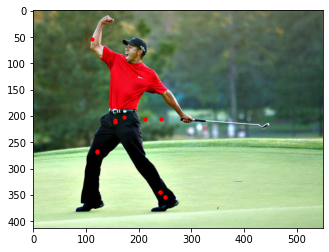

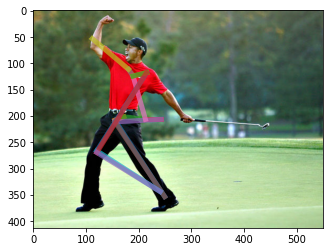

In [29]:
test_image = os.path.join(PROJECT_PATH, 'test_image.jpg')

image, keypoints = predict(model, test_image)
draw_keypoints_on_image(image, keypoints)
draw_skeleton_on_image(image, keypoints)

# 회고

지금까지 StackedHourglass Network를 기반으로 학습을 진행해왔다. 하지만 이전 챕터에서 살펴본 것처럼 simplebaseline 모델이 이보다 훨씬 간단한 구조임에도 더욱 좋은 성능을 보여주었다.   
실제로 그런 성능을 얻을 수 있는지 확인해보자.

1. simplebaseline 모델 완성하기
`simplebaseline.py`파일과 이전 챕터 simplebaseline 내용을 참고하여 모델을 완성해보자.
2. simplebaseline 모델로 변경하여 훈련하기
stackedhourglass를 학습시킨 코드의 모델 선언 부분을 simplebaseline 모델로 변경한 후 학습을 다시 진행해보자.
3. 두 모델의 비교
두 모델 동일한 Epoch 수 만큼 학습하여 Pose Estimation 결과와 학습 진행 결과를 비교해보자.   
가급적 두 모델 모두 3epoch 이상(5epoch 이상 권장) 학습하자.